In [ ]:
#| default_exp airsim_client


# Multirotor Client 
> Connects to the Airsim simulator and enables higher level procedures



In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| hide
# skip_showdoc: true to avoid running cells when rendering docs, and skip_exec: true to skip this notebook when running tests. 
# this should be a raw cell 

In [ ]:
#| export

from fastcore.utils import *
import random
import subprocess
import time
import numpy as np
import cv2
import UAV.airsim_python_client as airsim
# import airsim_python_client as airsim
from UAV.airsim_python_client import MultirotorClient
from pathlib import Path
from typing import List, Tuple, Union, Optional, Callable, Dict, Any

import logging


In [ ]:
#| export
logging.basicConfig(format='%(asctime)-8s,%(msecs)-3d %(levelname)5s [%(filename)10s:%(lineno)3d] %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.DEBUG)  # Todo add this to params
logger = logging.getLogger(__name__)

In [ ]:
#| hide
from fastcore.utils import *
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
%%capture
from UAV.utils.display import *
from UAV.utils.sim_linux import *
from matplotlib import pyplot as plt

In [ ]:
rs = RunSim("AirSimNH", settings="config/settings_high_res.json")

Starting Airsim  ['/home/jn/Airsim/AirSimNH/LinuxNoEditor/AirSimNH/Binaries/Linux/AirSimNH', '-ResX=800', '-ResY=600', '-windowed', '-settings=/home/jn/PycharmProjects/UAV/UAV/config/settings_high_res.json']
Started Airsim AirSimNH


In [ ]:
#| export
class AirSimClient(MultirotorClient, object):
    """Multirotor Client for the Airsim simulator with higher level procedures"""

    def __init__(self, ip = "", # rpc connection address
                 port:int = 41451, # rpc connection port
                 timeout_value = 3600): # timeout for client ping in seconds
        
        super(AirSimClient, self).__init__(ip, port, timeout_value)
        super().confirmConnection()
        self.objects = []
        
        
    def check_asset_exists(self,
                               name: str  # asset name
                               )->bool: # exists
        """Check if asset exists"""
        return name in super().simListAssets()


In [ ]:
#|eval: false
show_doc(AirSimClient)

---

[source](https://github.com/johnnewto/UAV/blob/main/UAV/airsim_client.py#L27){target="_blank" style="float:right; font-size:smaller"}

### AirSimClient

>      AirSimClient (ip='', port:int=41451, timeout_value=3600)

Multirotor Client for the Airsim simulator with higher level procedures

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| ip | str |  | rpc connection address |
| port | int | 41451 | rpc connection port |
| timeout_value | int | 3600 | timeout for client ping in seconds |

In [ ]:
#| export
@patch
def place_object(self:AirSimClient,  # airsim client
                name: str,  # asset name
                x: float,  # position x
                y: float,  # position y
                z: float,  # position z
                scale: float = 1.0,  # scale
                physics_enabled: bool = False,  # physics enabled
                ):
    """Place an object in the simulator
        First check to see if the asset it is based on exists"""
    
    if not self.check_asset_exists(name):
        print(f"Asset {name} does not exist.")
        return
    desired_name = f"{name}_spawn_{random.randint(0, 100)}"
    pose = airsim.Pose(position_val=airsim.Vector3r(x, y, z), )
    scale = airsim.Vector3r(scale, scale, scale)
    self.objects.append(super(AirSimClient, self).simSpawnObject(desired_name, name, pose, scale, physics_enabled))
    # self.objects.append(super().simSpawnObject(desired_name, name, pose, scale, physics_enabled))

In [ ]:
#|eval: false
show_doc(AirSimClient.place_object)

---

[source](https://github.com/johnnewto/UAV/blob/main/UAV/airsim_client.py#L48){target="_blank" style="float:right; font-size:smaller"}

### AirSimClient.place_object

>      AirSimClient.place_object (name:str, x:float, y:float, z:float,
>                                 scale:float=1.0, physics_enabled:bool=False)

Place an object in the simulator
First check to see if the asset it is based on exists

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| name | str |  | asset name |
| x | float |  | position x |
| y | float |  | position y |
| z | float |  | position z |
| scale | float | 1.0 | scale |
| physics_enabled | bool | False | physics enabled |

In [ ]:
asc = AirSimClient()

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)


In [ ]:
asc.place_object("Sofa_02", 5.0, 0.0, -1.0, scale=0.5 )

The sofa can be seen at the location with `rs.client.simGetObjectPose("Sofa_02")`
The sofa can be moved with `rs.move_asset(x,y,z,asset_name)`

In [ ]:
asc.simGetObjectPose("Sofa_02")

<Pose> {   'orientation': <Quaternionr> {   'w_val': nan,
    'x_val': nan,
    'y_val': nan,
    'z_val': nan},
    'position': <Vector3r> {   'x_val': nan,
    'y_val': nan,
    'z_val': nan}}

In [ ]:
#### Get image from one camera

In [ ]:
#| export
@patch
def get_image(self:AirSimClient,  # airsim client
              camera_name: str = "0",  # camera name
              rgb2bgr: bool = False,  # convert to bgr
              ) -> np.ndarray:  # image
    """Get an image from camera `camera_name`"""
    responses = super(AirSimClient, self).simGetImages([airsim.ImageRequest(camera_name, airsim.ImageType.Scene, False, False)])
    response = responses[0]
    img1d = np.frombuffer(response.image_data_uint8, dtype=np.uint8)
    img = img1d.reshape(response.height, response.width, 3)
    if rgb2bgr:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

In [ ]:
#|eval: false
show_doc(AirSimClient.get_image)

---

[source](https://github.com/johnnewto/UAV/blob/main/UAV/airsim_client.py#L70){target="_blank" style="float:right; font-size:smaller"}

### AirSimClient.get_image

>      AirSimClient.get_image (camera_name:str='0', rgb2bgr:bool=False)

Get an image from camera `camera_name`

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| camera_name | str | 0 | camera name |
| rgb2bgr | bool | False | convert to bgr |
| **Returns** | **ndarray** |  | **image** |

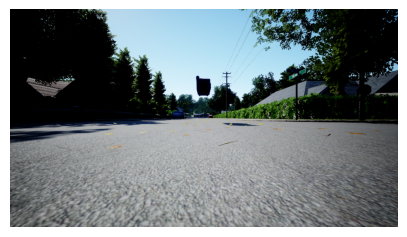

In [ ]:
img = asc.get_image(rgb2bgr=True)
ax = show_image(img)

In [ ]:
#| export
@patch
def get_images(self:AirSimClient,  # airsim client
               camera_names: list = ["0"],  # camera names
               rgb2bgr: bool = False,  # convert to rgb
               ) -> list[np.ndarray]:  # images
    """Get images from the simulator of cameras `camera_names`"""
    responses = super(AirSimClient, self).simGetImages(
        [airsim.ImageRequest(camera_name, airsim.ImageType.Scene, False, False) for camera_name in camera_names])
    images = []
    for response in responses:
        img1d = np.frombuffer(response.image_data_uint8, dtype=np.uint8)
        img = img1d.reshape(response.height, response.width, 3)
        if rgb2bgr:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return images


In [ ]:
#|eval: false
show_doc(AirSimClient.get_images)

---

[source](https://github.com/johnnewto/UAV/blob/main/UAV/airsim_client.py#L85){target="_blank" style="float:right; font-size:smaller"}

### AirSimClient.get_images

>      AirSimClient.get_images (camera_names:list=['0'], rgb2bgr:bool=False)

Get images from the simulator of cameras `camera_names`

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| camera_names | list | ['0'] | camera names |
| rgb2bgr | bool | False | convert to rgb |
| **Returns** | **list** |  | **images** |

> Note this seems to be slow

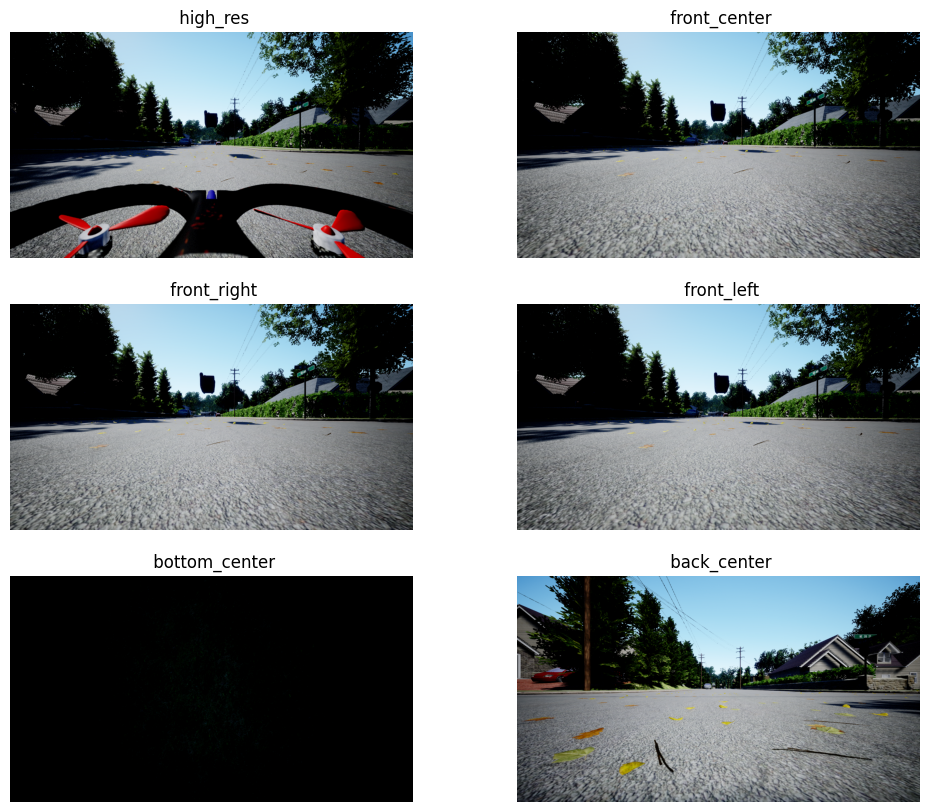

In [ ]:
cams = ["high_res", "front_center", "front_right", "front_left", "bottom_center", "back_center"]
imgs = asc.get_images(cams, rgb2bgr=True)

_,axs = plt.subplots(3,2,figsize=(12,10))
for i,ax in enumerate(axs.flatten()): show_image(imgs[i], ax=ax, title=f' {cams[i]}')

In [ ]:
#| export
@patch
def get_state(self:AirSimClient) -> MultirotorClient:
    """Get the state of the drone"""
    return self.simGetGroundTruthKinematics()


In [ ]:
#|eval: false
show_doc(AirSimClient.get_state)

---

[source](https://github.com/johnnewto/UAV/blob/main/UAV/airsim_client.py#L104){target="_blank" style="float:right; font-size:smaller"}

### AirSimClient.get_state

>      AirSimClient.get_state ()

Get the state of the drone

In [ ]:
#| export
@patch
def takeoff(self:AirSimClient,  # airsim client
            timeout: float = 5.0,  # timeout
            ) -> bool:  # success
    """Takeoff the drone"""
    return super().takeoffAsync(timeout_sec=timeout).join()

In [ ]:
#|eval: false
show_doc(AirSimClient.takeoff)

---

[source](https://github.com/johnnewto/UAV/blob/main/UAV/airsim_client.py#L111){target="_blank" style="float:right; font-size:smaller"}

### AirSimClient.takeoff

>      AirSimClient.takeoff (timeout:float=5.0)

Takeoff the drone

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| timeout | float | 5.0 | timeout |
| **Returns** | **bool** |  | **success** |

In [ ]:
rs.exit()

Airsim exited with rc = 143


In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()